<h1 align=right> Fine-Tuning BERT for Text Classification with TensorFlow</h2>

In this project we'll see how to fine-tune BERT for a multi-class classification problem using Tensorflow and tf_hub . 

The pre-trained BERT models are available at [tensorflow hub](https://tfhub.dev/). 

# Table of contents:
- **[Step 1]()**: Setting up TensorFlow and Colab Runtime
- **[Step 2]()**: Clonning tensorflow Model garden repo and installing required dependencies 
- **[Step 3]()**: Downloading and Importing the BBC News Dataset
- **[Step 4]()**: Custom cleaning the data before passing to BERT tokenizer
- **[Step 5]()**: Creating tf.data.Datasets for Training and Evaluation
- **[Step 6]()**: Downloading a Pre-trained BERT Model from TensorFlow Hub
- **[Step 7]()**: Tokenizing and Preprocessing Text for BERT
- **[Step 8]()**: Wraping a Python Function into a TensorFlow op for Eager Execution
- **[Step 9]()**: Creating a TensorFlow Input Pipeline with `tf.data`
- **[Step 10]()**: Adding a Classification Head to the BERT `hub.KerasLayer`
- **[Step 11]()**: Fine-Tuning BERT for Text Classification
- **[Step 12]()**: Saving and evaluating the BERT Model on new data

### Step 1: Setting up TensorFlow and Colab Runtime

Go to above menu bar and select `Runtime` then from Dropdown menu select `change runtime type` and then choose `GPU` from that to enable it . Lastly try to connect GPU with `Connect` button at upper right corner of notebook 

In [ ]:
import tensorflow as tf
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")
!nvidia-smi

GPU is available
Sat Jun 26 07:38:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                       

### Step 2: Clonning tensorflow Model garden repo and installing required dependencies 

You have to restart your kernel after executing below 2 cells by clicking on same `Runtime` menu and then choosing `Restart runtime`

In [ ]:
# Tensorflow official models for NLP and CV
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 506), reused 1386 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 33.33 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime after this execution

     |████████████████████████████████| 7.0MB 8.4MB/s 
     |████████████████████████████████| 194kB 32.2MB/s 
     |████████████████████████████████| 15.7MB 189kB/s 
     |████████████████████████████████| 9.9MB 34.9MB/s 
     |████████████████████████████████| 296kB 51.6MB/s 
     |████████████████████████████████| 102kB 15.1MB/s 
     |████████████████████████████████| 28.5MB 89kB/s 
     |████████████████████████████████| 215kB 58.1MB/s 
     |████████████████████████████████| 3.9MB 37.6MB/s 
     |████████████████████████████████| 686kB 37.9MB/s 
     |████████████████████████████████| 358kB 45.8MB/s 
     |████████████████████████████████| 1.2MB 38.5MB/s 
     |████████████████████████████████| 10.3MB 209kB/s 
     |████████████████████████████████| 38.2MB 74kB/s 
     |████████████████████████████████| 645kB 44.8MB/s 
     |████████████████████████████████| 3.0MB 39.6MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 81kB 11.4MB/s

### Step 3: Downloading and Importing the BBC News Dataset 

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
# libraries from clonned repo
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization  # to create AdamW optimizer
tf.get_logger().setLevel('ERROR')


In [ ]:
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("Tensorflow version: ", tf.version.VERSION)

Eager mode:  True
Hub version:  0.12.0
Tensorflow version:  2.5.0


In [ ]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.width',1000)
pd.set_option('max_colwidth', 1000) 
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stpwrds = set(stopwords.words('english'))
stpwrds.discard('not')
stpwrds.discard('no')
import os
import re
from nltk.stem import WordNetLemmatizer as wnl
import sklearn


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Data is fetched and stored in tmp folder with name bbc-text.csv
!wget --no-check-certificate \
    https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2021-06-26 08:45:13--  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.02s   

2021-06-26 08:45:13 (244 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [ ]:
df = pd.read_csv('/tmp/bbc-text.csv' , delimiter = ',')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home theatre systems plasma high-definition tvs and digital video recorders moving into the living room the way people watch tv will be radically different in five years time. that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend programmes and other content will be delivered to viewers via home networks through cable satellite telecoms companies and broadband service providers to front rooms and portable devices. one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes like the us s tivo and the uk s sky+ system allow people to record store play pause and forward wind tv programmes when they want. essentially the technology allows for much more personalised tv. they are also being built-in to h...
1,business,worldcom boss left books alone former worldcom boss bernie ebbers who is accused of overseeing an $11bn (£5.8bn) fraud never made accounting decisions a witness has told jurors. david myers made the comments under questioning by defence lawyers who have been arguing that mr ebbers was not responsible for worldcom s problems. the phone company collapsed in 2002 and prosecutors claim that losses were hidden to protect the firm s shares. mr myers has already pleaded guilty to fraud and is assisting prosecutors. on monday defence lawyer reid weingarten tried to distance his client from the allegations. during cross examination he asked mr myers if he ever knew mr ebbers make an accounting decision . not that i am aware of mr myers replied. did you ever know mr ebbers to make an accounting entry into worldcom books mr weingarten pressed. no replied the witness. mr myers has admitted that he ordered false accounting entries at the request of former worldcom chief fina...
2,sport,tigers wary of farrell gamble leicester say they will not be rushed into making a bid for andy farrell should the great britain rugby league captain decide to switch codes. we and anybody else involved in the process are still some way away from going to the next stage tigers boss john wells told bbc radio leicester. at the moment there are still a lot of unknowns about andy farrell not least his medical situation. whoever does take him on is going to take a big big gamble. farrell who has had persistent knee problems had an operation on his knee five weeks ago and is expected to be out for another three months. leicester and saracens are believed to head the list of rugby union clubs interested in signing farrell if he decides to move to the 15-man game. if he does move across to union wells believes he would better off playing in the backs at least initially. i m sure he could make the step between league and union by being involved in the centre said wells. ...
3,sport,yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier league leaders yeading in the fa cup third round. the game - arguably the highlight of the draw - is a potential money-spinner for non-league yeading who beat slough in the second round. conference side exeter city who knocked out doncaster on saturday will travel to old trafford to meet holders manchester united in january. arsenal were drawn at home to stoke and chelsea will play host to scunthorpe. the only other non-league side in the draw are hinckley united who held brentford to a goalless draw on sunday. they will meet league one leaders luton if they win their replay against martin allen s team at griffin park. a number of premiership teams face difficult away games against championship sides on the weekend of 8/9 january. third-placed everton visit plymouth liverpool travel to burnley crystal palace go to sunderland fulham face carling cup semi-finalists watford bolton...
4,entertainment,ocea

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [ ]:
# For simplicity we'll be taking only 3 classes for this task
df = df[df['category'].isin(['sport','business','entertainment'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1407 entries, 1 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  1407 non-null   object
 1   text      1407 non-null   object
dtypes: object(2)
memory usage: 33.0+ KB


### Step 4: Custom cleaning the data before passing to BERT tokenizer 


In [ ]:
def clean_text(text):  
    lower = text.lower()
    words = re.sub(r"(@[A-Za-z]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", lower )  
    #pattren = r"[^\w\s\d]"
    #words = re.sub(pattren, "", lower)
    words2 = words.split()
    #print(words2)
    final_words =  [wnl().lemmatize(word , pos = 'v') for word in words2 if word not in stopwords.words('english')]
    final_words = ' '.join(final_words)
    return(final_words)
    
df['Cleaned-text'] = df['text'].apply(clean_text)
df.head()

,category,text,Cleaned-text
1,business,worldcom boss left books alone former worldcom boss bernie ebbers who is accused of overseeing an $11bn (£5.8bn) fraud never made accounting decisions a witness has told jurors. david myers made the comments under questioning by defence lawyers who have been arguing that mr ebbers was not responsible for worldcom s problems. the phone company collapsed in 2002 and prosecutors claim that losses were hidden to protect the firm s shares. mr myers has already pleaded guilty to fraud and is assisting prosecutors. on monday defence lawyer reid weingarten tried to distance his client from the allegations. during cross examination he asked mr myers if he ever knew mr ebbers make an accounting decision . not that i am aware of mr myers replied. did you ever know mr ebbers to make an accounting entry into worldcom books mr weingarten pressed. no replied the witness. mr myers has admitted that he ordered false accounting entries at the request of former worldcom chief fina...,worldcom boss leave book alone former worldcom boss bernie ebbers accuse oversee bn bn fraud never make account decisions witness tell jurors david myers make comment question defence lawyers argue mr ebbers responsible worldcom problems phone company collapse prosecutors claim losses hide protect firm share mr myers already plead guilty fraud assist prosecutors monday defence lawyer reid weingarten try distance client allegations cross examination ask mr myers ever know mr ebbers make account decision aware mr myers reply ever know mr ebbers make account entry worldcom book mr weingarten press reply witness mr myers admit order false account entries request former worldcom chief financial officer scott sullivan defence lawyers try paint mr sullivan admit fraud testify later trial mastermind behind worldcom account house card mr ebbers team meanwhile look portray affable boss admission pe graduate economist whatever abilities mr ebbers transform worldcom relative unknown bn telecom...
2,sport,tigers wary of farrell gamble leicester say they will not be rushed into making a bid for andy farrell should the great britain rugby league captain decide to switch codes. we and anybody else involved in the process are still some way away from going to the next stage tigers boss john wells told bbc radio leicester. at the moment there are still a lot of unknowns about andy farrell not least his medical situation. whoever does take him on is going to take a big big gamble. farrell who has had persistent knee problems had an operation on his knee five weeks ago and is expected to be out for another three months. leicester and saracens are believed to head the list of rugby union clubs interested in signing farrell if he decides to move to the 15-man game. if he does move across to union wells believes he would better off playing in the backs at least initially. i m sure he could make the step between league and union by being involved in the centre said wells. ...,tigers wary farrell gamble leicester say rush make bid andy farrell great britain rugby league captain decide switch cod anybody else involve process still way away go next stage tigers boss john well tell bbc radio leicester moment still lot unknowns andy farrell least medical situation whoever take go take big big gamble farrell persistent knee problems operation knee five weeks ago expect another three months leicester saracens believe head list rugby union club interest sign farrell decide move man game move across union well believe would better play back least initially sure could make step league union involve centre say well think england would prefer progress position back row make use rugby league skills within forward jury whether cross divide club balance strike cost gamble option bring readymade replacement
3,sport,yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier league leaders yeading in the fa cup third round. the game

In [ ]:
df.drop(columns=['text'],inplace=True)
df.head(2)

,category,Cleaned-text
1,business,worldcom boss leave book alone former worldcom boss bernie ebbers accuse oversee bn bn fraud never make account decisions witness tell jurors david myers make comment question defence lawyers argue mr ebbers responsible worldcom problems phone company collapse prosecutors claim losses hide protect firm share mr myers already plead guilty fraud assist prosecutors monday defence lawyer reid weingarten try distance client allegations cross examination ask mr myers ever know mr ebbers make account decision aware mr myers reply ever know mr ebbers make account entry worldcom book mr weingarten press reply witness mr myers admit order false account entries request former worldcom chief financial officer scott sullivan defence lawyers try paint mr sullivan admit fraud testify later trial mastermind behind worldcom account house card mr ebbers team meanwhile look portray affable boss admission pe graduate economist whatever abilities mr ebbers transform worldcom relative unknown bn telecom...
2,sport,tigers wary farrell gamble leicester say rush make bid andy farrell great britain rugby league captain decide switch cod anybody else involve process still way away go next stage tigers boss john well tell bbc radio leicester moment still lot unknowns andy farrell least medical situation whoever take go take big big gamble farrell persistent knee problems operation knee five weeks ago expect another three months leicester saracens believe head list rugby union club interest sign farrell decide move man game move across union well believe would better play back least initially sure could make step league union involve centre say well think england would prefer progress position back row make use rugby league skills within forward jury whether cross divide club balance strike cost gamble option bring readymade replacement


In [ ]:
## Encoding categorical data to integer labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])
print(list(le.classes_))
print(df['category'].dtype)

['business', 'entertainment', 'sport']
int64


In [ ]:
df['category'][:5]

1    0
2    2
3    2
4    1
7    2
Name: category, dtype: int64

### Step 5: Creating tf.data.Datasets for Training and Evaluation

In [ ]:
from sklearn.model_selection import train_test_split

train_df , remaining = train_test_split(df, random_state = 42 , train_size = 0.9 , stratify = df.category.values )
test_df , remaining = train_test_split(remaining, random_state = 42 , train_size = 0.9 , stratify = remaining.category.values )

train_df.shape , test_df.shape

((1266, 2), (126, 2))

<AxesSubplot:ylabel='category'>

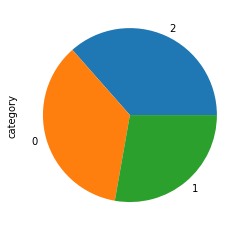

In [ ]:
test_df['category'].value_counts().plot(kind='pie')

In [ ]:
# Creating input pipeline on CPU to use GPU efficiently 
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['Cleaned-text'].values , train_df['category'].values ))
  test_data = tf.data.Dataset.from_tensor_slices((test_df['Cleaned-text'].values , test_df['category'].values ))

  for text , label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'us tv cut nudity bbc film us tv network edit bbc film dirty war avoid show front nude woman scrub fictional chemical attack worth show nonessential nude scenes indecency complaints aggressively pursue us tv watchdogs say pbs jacoba atlas dirty war screen uncut bbc one last september depict dirty bomb attack city london also screen uncut us cable channel hbo january pbs say use extra footage broadcast show woman discreet angle instead us federal communications commission fin cbs last autumn singer janet jackson wardrobe malfunction breast expose dance routine justin timberlake many us network broadcasters nervous air nudity violence bad language ms atlas say pbs could put financially risk show uncut version dirty war could also deter many individual station air important film want pick battle say add pbs private nonprofit media enterprise own operate nation public television station bolder screen nonfiction historical program pbs see virtually us home tv describe trust commu

In [ ]:
# Cheking the max/min/average source sequence length
source_length_list=[]
for source in df['Cleaned-text']:
  source_length_list.append(len(source.split(' ')))
max_seq_length = max(source_length_list)
min_seq_length = min(source_length_list)
avg_seq_lenght = np.average(source_length_list)
print(" Maximum source length " , max_seq_length)
print(" Minimum source length " , min_seq_length)
print(" Average source length " , avg_seq_lenght)

 Maximum source length  1764
 Minimum source length  61
 Average source length  186.11513859275053


### Step 6: Downloading a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0 , 1 , 2] # Label categories
max_seq_length = 200 # maximum length of (token) input sequences . it can be any number
train_batch_size = 16 # batch size ( 16 choosen to avoid Out-Of-Memory errors)


# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4" , trainable = True)


vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file , do_lower_case)

In [ ]:
tokenizer.wordpiece_tokenizer.tokenize(str(df['Cleaned-text'].tail(1)))

['222',
 '##4',
 'so',
 '##unes',
 '##s',
 'delight',
 'euro',
 'progress',
 'boss',
 'graeme',
 'so',
 '##unes',
 '##s',
 'felt',
 'newcastle',
 'never',
 'really',
 'danger',
 'go',
 'uefa',
 'cup',
 'hee',
 '##ren',
 '##ve',
 '##en',
 'early',
 'goal',
 'follow',
 'alan',
 'shear',
 '##er',
 'strike',
 'earn',
 'win',
 'place',
 'uefa',
 'cup',
 'last',
 'obviously',
 'win',
 'first',
 'leg',
 'give',
 'us',
 'great',
 'advantage',
 'say',
 'aggregate',
 'victory',
 'get',
 'goals',
 'early',
 'mind',
 'players',
 'job',
 'do',
 'get',
 'goal',
 'perhaps',
 'make',
 'us',
 'bite',
 'nervous',
 'shear',
 '##er',
 'goal',
 'move',
 'within',
 'jackie',
 'mil',
 '##burn',
 'club',
 'score',
 'record',
 'mag',
 '##pies',
 'so',
 '##unes',
 '##s',
 'say',
 'think',
 'beat',
 'record',
 'would',
 'bear',
 'decision',
 'retire',
 'end',
 'season',
 'think',
 'get',
 'year',
 'would',
 'want',
 'stay',
 'next',
 'year',
 'anyway',
 'add',
 'strike',
 'ball',
 'well',
 'always',
 'do',
 'thi

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize(str(df['Cleaned-text'].tail(1))))

[19015,
 2549,
 2061,
 26639,
 2015,
 12208,
 9944,
 5082,
 5795,
 21840,
 2061,
 26639,
 2015,
 2371,
 8142,
 2196,
 2428,
 5473,
 2175,
 6663,
 2452,
 18235,
 7389,
 3726,
 2368,
 2220,
 3125,
 3582,
 5070,
 18330,
 2121,
 4894,
 7796,
 2663,
 2173,
 6663,
 2452,
 2197,
 5525,
 2663,
 2034,
 4190,
 2507,
 2149,
 2307,
 5056,
 2360,
 9572,
 3377,
 2131,
 3289,
 2220,
 2568,
 2867,
 3105,
 2079,
 2131,
 3125,
 3383,
 2191,
 2149,
 6805,
 6091,
 18330,
 2121,
 3125,
 2693,
 2306,
 9901,
 23689,
 8022,
 2252,
 3556,
 2501,
 23848,
 13046,
 2061,
 26639,
 2015,
 2360,
 2228,
 3786,
 2501,
 2052,
 4562,
 3247,
 11036,
 2203,
 2161,
 2228,
 2131,
 2095,
 2052,
 2215,
 2994,
 2279,
 2095,
 4312,
 5587,
 4894,
 3608,
 2092,
 2467,
 2079,
 2228,
 2373,
 6393,
 3786,
 9653,
 2061,
 26639,
 2015,
 2036,
 3477,
 7050,
 14718,
 2728,
 2540,
 2172,
 15908,
 2886,
 2377,
 2034,
 2431,
 2428,
 2092,
 2673,
 2215,
 2898,
 2447,
 2925,
 3531,
 2360,
 100,
 100,
 26718,
 18863,
 29627,
 4874]

### Step 7 : Tokenizing and Preprocessing Text for BERT


<div align="right">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [ ]:
# This provides a function to convert each row to input features and label ( as required by BERT)

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0 , example , label_list , max_seq_length , tokenizer)
  
  return (feature.input_ids , feature.input_mask , feature.segment_ids , feature.label_id)
  

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

### Step 8: Wraping a Python Function into a TensorFlow op for Eager Execution

In [ ]:
def to_feature_map(text, label):
  input_ids , input_mask , segment_ids , label_id = tf.py_function(to_feature , inp = [text , label],
                                                                   Tout = [tf.int32 , tf.int32 , tf.int32 , tf.int32])
  
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      "input_word_ids": input_ids,
       "input_mask": input_mask,
       "input_type_ids": segment_ids
  }

  return(x,label_id)

### Step 9: Creating a TensorFlow Input Pipeline with `tf.data`

In [ ]:
# Running everything on CPU
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(16 , drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  test_data = (test_data.map(to_feature_map,
                               num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(16 , drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):





In [ ]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(16, 200), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(16, 200), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(16, 200), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16,), dtype=tf.int32, name=None))

In [ ]:
# valid data spec
test_data.element_spec

({'input_mask': TensorSpec(shape=(16, 200), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(16, 200), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(16, 200), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16,), dtype=tf.int32, name=None))

In [ ]:
train_data

<PrefetchDataset shapes: ({input_word_ids: (16, 200), input_mask: (16, 200), input_type_ids: (16, 200)}, (16,)), types: ({input_word_ids: tf.int32, input_mask: tf.int32, input_type_ids: tf.int32}, tf.int32)>

### Step 10: Adding a Classification Head to the BERT `hub.KerasLayer`

<div align="right">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [ ]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name = "input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name = "input_mask")
  input_type_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name = "input_type_ids")
  
  encoder_inputs = dict(input_word_ids = input_word_ids ,input_mask = input_mask,input_type_ids = input_type_ids  )
  bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4" , trainable = True)
  
  outputs  = bert_layer(encoder_inputs)
  pooled_output = outputs["pooled_output"]      
  
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(3, activation='softmax', name="output")(drop)

  model = tf.keras.Model(
      inputs={
      'input_word_ids': input_word_ids,
       'input_mask': input_mask,
       'input_type_ids': input_type_ids
  },
      outputs=output)
  return model


### Step 11: Fine-Tuning BERT for Text Classification

### Optimizor

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [`AdamW`](https://arxiv.org/abs/1711.05101).

For the learning rate (init_lr), we will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.metrics.Accuracy()

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
model = create_model()
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
keras_layer_4 (KerasLayer)      {'encoder_outputs':  109482241   input_mask[0][0]                 
                                                                 input_type_ids[0][0]       

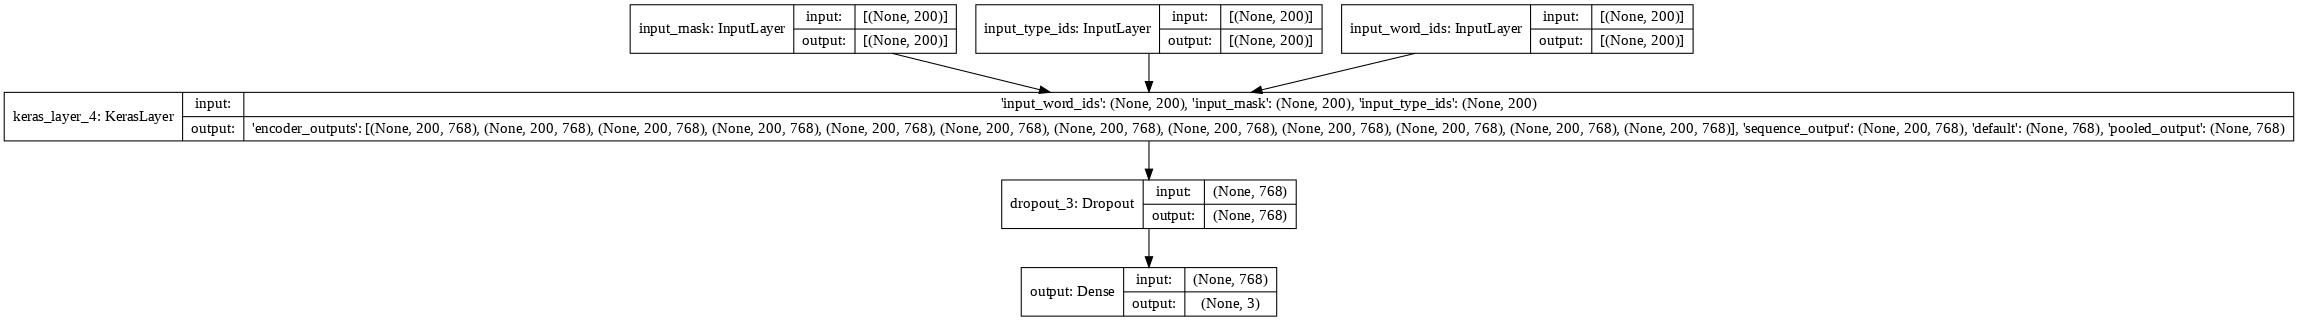

In [ ]:
tf.keras.utils.plot_model(model = model, show_shapes = True, dpi=76 )

In [ ]:
for text , labls in train_data.take(1):
  print(labls)

tf.Tensor([1 1 1 1 0 2 0 0 1 0 1 2 0 2 0 2], shape=(16,), dtype=int32)


In [ ]:
# Train model

history = model.fit(train_data,
                    validation_data = test_data,
                    epochs = epochs,
                    verbose = 1)

Epoch 1/5
79/79 [==============================] - 81s 779ms/step - loss: 0.1713 - accuracy: 0.9328 - val_loss: 6.8196e-04 - val_accuracy: 1.0000
Epoch 2/5
79/79 [==============================] - 65s 772ms/step - loss: 0.0122 - accuracy: 0.9976 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 3/5
79/79 [==============================] - 66s 789ms/step - loss: 0.0041 - accuracy: 0.9984 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 4/5
79/79 [==============================] - 66s 786ms/step - loss: 0.0032 - accuracy: 0.9984 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 5/5
79/79 [==============================] - 66s 786ms/step - loss: 9.9602e-04 - accuracy: 1.0000 - val_loss: 3.1118e-04 - val_accuracy: 1.0000


### Step 12: Saving and evaluating the BERT Model on new data

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

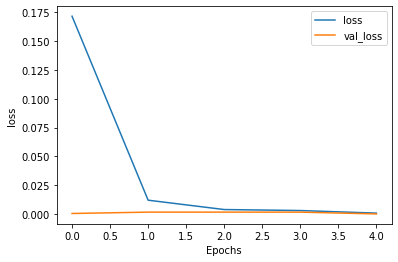

In [ ]:
plot_graphs(history,'loss')

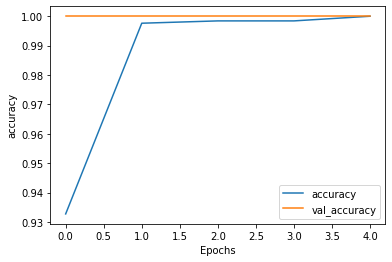

In [ ]:
plot_graphs(history,'accuracy')

In [ ]:
# Evaluating on new data

example_list = ["band aid single storm new version band aid song know christmas go straight number one uk single chart charity record also tip year christmas number one feature vocals like chris martin dido robbie williams sugababes original version christmas number one sell copy first week million total release us reach number single chart however band aid go release us despite sell many countries around world us record shop stock import version know christmas say sell well los angeles new york british star appear current record dido coldplay chris martin well know music fan across atlantic along u frontman bono record company universal responsible global distribution single available across europe asia south america canada music fan us still able access song download band aid official website group highprofile american star know usa africa come together record fundraise single world song write lionel richie michael jackson quincy jones producer top us chart three weeks go win grammy award best",
                "leary agree new villa contract aston villa boss david leary sign threeandahalf year contract extension thursday secure future club summer leary future question villa chairman doug ellis say happy secure deal david record since arrival excellent share board amibitions take club forward tell villa website reason important get right leary put pen paper deal sort righthand men roy aitken steve mcgregor important roy steve integral part team stay time leary say thursday ahead sign new deal someone try put aston villa back belong challenge earlier december rumour leary would quit offer new deal end season deny say happy take challenge improve villa fortunes long term want make sure end five years would charge villa achieve top six finish premiership regular basis say leary take villa park may achieve take next step forward need bring quality players would like couple next month possible set us way meanwhile leary rap skipper olof mellberg comment sunday derby birmingham mellberg speak"]

valid_data = tf.data.Dataset.from_tensor_slices((example_list , [1,2])) # 1 refers to 'entertainment' and 2 refers to 'sport'
valid_data = (valid_data.map(to_feature_map).batch(1))
valid_data.element_spec

({'input_mask': TensorSpec(shape=(None, 200), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(None, 200), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(None, 200), dtype=tf.int32, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
preds = model.predict(valid_data)

In [ ]:
# It's really accurate !!!
predicted_values = tf.nn.softmax(preds)
predicted_values = [np.argmax(x) for x in predicted_values]
predicted_values

[1, 2]

## Exporting Model for inference

In [ ]:
dataset_name = 'BBC'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))
print(saved_model_path)
model.save(saved_model_path, include_optimizer=False)


./BBC_bert


In [ ]:
ls ./BBC_bert

assets/  keras_metadata.pb  saved_model.pb  variables/


In [ ]:
reloaded_model = tf.keras.models.load_model(saved_model_path)
reloaded_model

In [ ]:
def evaluate(dum_model):
  preds = dum_model.predict(valid_data)
  predicted_values = tf.nn.softmax(preds)
  predicted_values = [np.argmax(x) for x in predicted_values]
  return predicted_values

print('Results from the saved model:')
reloaded_results = evaluate(reloaded_model)
print(reloaded_results)

print('Results from the model in memory:')
original_results = evaluate(model)
print(original_results)

Results from the saved model:
[1, 2]
Results from the model in memory:
[1, 2]
